# Graphs from the NSPN 2K cohort questionaire data

These graph analyses are created by Kirstie, started on 11th May 2016, based on correlation matrices from Jan.

In [1]:
import community
import forceatlas2
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import rc
import matplotlib as mpl
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import sys
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1)

%load_ext autoreload
%autoreload 2

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
sys.path.append('C:\Users\Kirstie\Dropbox\GitHub\NSPN_CorticalMyelination\SCRIPTS')
from make_graphs import *
from make_corr_matrices import *
from make_figures import *

In [3]:
# Set some variables so you can find the data
corr_mat_dir = 'C:\Users\Kirstie\Dropbox\KW_NSPN\NCAAPS\PSYCHOPATHOLOGY\MODULES'
results_dict_file = os.path.join(corr_mat_dir, 'results_dict.p')

In [15]:
def show_network(corr_mat_file, cost=15, n_rand=10, plotting_dict=None, sep=',', header=True):
    
    name = os.path.basename(corr_mat_file).split('_')[1].replace('.csv', '').capitalize()
    
    corr_mat_df = pd.read_csv(corr_mat_file, sep=sep, header=header)
    M = corr_mat_df.values
    M_abs = np.abs(M)
    G = graph_at_cost(M_abs, cost)
    M_cost = nx.to_numpy_matrix(G)
    
    # Create your plotting dictionary
    # These are all the values you need to create the summary figure
    if not plotting_dict:
        print 'Creating the plotting dict - may take a little while'
        plotting_dict = create_plotting_dict(G, n_rand=n_rand)
    
    rich_edges, rich_nodes = rich_edges_nodes(G)
    plotting_dict['rich_edges'] = rich_edges
    plotting_dict['rich_nodes'] = rich_nodes

    # Re-order the matrix according to the modules
    corr_mat_reorder_df = corr_mat_df.iloc[plotting_dict['module_order'], plotting_dict['module_order']]
    M_reorder = corr_mat_reorder_df.values
    M_cost = nx.to_numpy_matrix(G)
    M_cost_reorder = M_cost[plotting_dict['module_order'], :]
    M_cost_reorder = M_cost_reorder[:, plotting_dict['module_order']]
    
    # Make the figure
    
    plotting_dict['figure_name'] = corr_mat_file.replace('.csv', '_SummaryFig_Cost_{}.png'.format(cost))
    plotting_dict['title'] = '{} {:2.0f}%'.format(name, cost)
    make_summary_fig(G, M, M_reorder, M_cost_reorder, plotting_dict)
    
    # Report which items are in each module
    plotting_dict['module_items_name'] = corr_mat_file.replace('.csv', '_ModuleItems_Cost_{}.csv'.format(cost))
    report_module_items(corr_mat_df, plotting_dict)
    
    return plotting_dict

In [5]:
def create_plotting_dict(G, n_rand=10, R_list=None, R_nodal_partition_list=None):
    # Create your plotting dictionary
    # These are all the values you need to create the summary figure
    plotting_dict = {}

    # Split up the graph into modules
    nodal_partition = calc_nodal_partition(G)
    module_partition, module_order, module_colors, nodal_colors = color_by_module(nodal_partition)

    plotting_dict['module_partition'] = module_partition
    plotting_dict['module_order'] = module_order
    plotting_dict['module_colors'] = module_colors
    plotting_dict['nodal_colors'] =  nodal_colors
    
    # Show the spring layout and the layout that emphasises modules
    # a little more clearly
    plotting_dict['pos_spring'] = nx.spring_layout(G)
    plotting_dict['pos_forceatlas2'] = forceatlas2.forceatlas2_networkx_layout(G, gravity=1)
    
    # Create a bunch of random networks
    R_list, R_nodal_partition_list = make_random_list(G, n_rand=n_rand)
    
    # Calculate the global network measures
    plotting_dict['global_measures'] = calculate_global_measures(G,
                                                           R_list=R_list,
                                                           nodal_partition=nodal_partition,
                                                           R_nodal_partition_list=R_nodal_partition_list)
    
    # Calculate the rich club curve
    deg, rc, rc_rand = rich_club(G, R_list=R_list)
    
    plotting_dict['rc'] = rc
    plotting_dict['rc_rand'] = rc_rand
    
    rich_edges, rich_nodes = rich_edges_nodes(G)
    plotting_dict['rich_edges'] = rich_edges
    plotting_dict['rich_nodes'] = rich_nodes

    return plotting_dict

In [6]:
def color_by_module(nodal_partition):
    
    # The nodal partition has nodes as keys and modules
    # as values. Here we make a module partition that has
    # modules as keys and nodes as values
    module_partition = {}
    for m,n in zip(nodal_partition.values(),nodal_partition.keys()):
        try:
            module_partition[m].append(n)
        except KeyError:
            module_partition[m] = [n]
            
    # Create a list of the nodes in module order
    module_order = []
    for key in module_partition.keys():
        module_order += module_partition[key]
    
    # Now we need to assign a color to each of the modules
    module_colors = sns.color_palette('husl', n_colors=len(module_partition.keys()))
    # And then map the appropriate color to the nodes
    nodal_colors = [ module_colors[i] for i in nodal_partition.values() ]

    return module_partition, module_order, module_colors, nodal_colors

In [7]:
def make_summary_fig(G, M_orig, M_reorder, M_cost_reorder, plotting_dict):
    
    sns.set_context('poster', font_scale=1)
    
    fig, big_ax = plt.subplots(figsize=(18,10))
    
    # Top row
    grid = gridspec.GridSpec(1, 3)
    grid.update(bottom=0.4, left=0.1, right=0.94, wspace=0, hspace=0)
    ax0 = plt.subplot(grid[0,0])
    ax1 = plt.subplot(grid[0,1])
    ax2 = plt.subplot(grid[0,2])
    
    plot_reordered_mat(M_reorder, 
                           M_cost_reorder,
                           plotting_dict['module_partition'], 
                           plotting_dict['module_colors'],
                           ax=ax0)
    ax0.axis('off')
    x_min, x_max = ax0.get_xlim()
    y_min, y_max = ax0.get_ylim()
    ax0.axhline(y_min, linewidth=2, color = 'k')
    ax0.axvline(x_min, linewidth=2, color = 'k')
    
    nx.draw_networkx(G,
                     pos=plotting_dict['pos_spring'], 
                     node_color=plotting_dict['nodal_colors'],
                     with_labels=False,
                     ax=ax1)
    ax1.axis('off')

    nx.draw_networkx(G,
                     pos=plotting_dict['pos_forceatlas2'], 
                     node_color=plotting_dict['nodal_colors'],
                     with_labels=False,
                     ax=ax2)
    ax2.axis('off')

    plt.figtext(0.24, 0.93, 'Reordered Matrix', verticalalignment='top', horizontalalignment='center', size=20)
    plt.figtext(0.52, 0.93, 'Spring Layout', verticalalignment='top', horizontalalignment='center', size=20)
    plt.figtext(0.8, 0.93, 'ForceAtlas2 Layout', verticalalignment='top', horizontalalignment='center', size=20)

    # Bottom row
    grid = gridspec.GridSpec(1, 4, wspace=0.35, left=0.1, right=0.95)
    grid.update(top=0.4)
    ax0 = plt.subplot(grid[0,0])
    ax1 = plt.subplot(grid[0,1])
    ax2 = plt.subplot(grid[0,2])
    ax3 = plt.subplot(grid[0,3])
    
    # Correlation distribution
    plot_corr_dist(np.abs(M_orig), color=sns.color_palette()[1], label='Abs', ax=ax0)
    plot_corr_dist(M_orig, label='Orig', ax=ax0)
    
    # Degree distribution
    plot_degree_dist(G, ax=ax1, ER=False, x_max=None)
    
    # Rich club curve
    plot_rich_club(plotting_dict['rc'],
                   plotting_dict['rc_rand'],
                   ax=ax2,
                   x_max=None)

    # Network measures
    plot_network_measures(plotting_dict['global_measures'], ax=ax3)
        
    plt.figtext(0.02, 0.5,
                plotting_dict['title'],
                rotation=90, 
                verticalalignment='center',
                horizontalalignment='left',
                size=30)
    
    fig.savefig(plotting_dict['figure_name'], dpi=50, bbox_inches=0)
    
    plt.show()

In [8]:
def report_module_items(corr_mat_df, plotting_dict):
    
    module_partition = plotting_dict['module_partition']
    module_items_name = plotting_dict['module_items_name']
    module_colors = plotting_dict['module_colors']
    title = plotting_dict['title']
    rich_nodes = plotting_dict['rich_nodes']
    
    # Turn on latex usage
    rc('text', usetex=True)
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Bitstream Vera Sans'

    # First just write them out into a csv file
    # The formatting is annoying because they're rows when it
    # would make more sense to be columns, but as they're
    # different lengths I'm just not going to worry about it
    # If you're reading them in excel you can just transpose them anyway!
    with open(module_items_name, 'w') as f:
        for i, module in enumerate(module_partition.keys()):
            item_list = ['{}'.format(module)]
            for item in module_partition[module]:
                item_list += [corr_mat_df.columns[item]]
            f.write(','.join(item_list))
            f.write('\n')

    # Then, we're going to put each into a figure which will hopefully look
    # super cool and nice and easy to read
    
    # Start by figuring out the right shape for the grid
    n_cols = 6
    n_rows = 2
    if 'All' in title:
        n_rows = 3
        
    fig, ax_list = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*6))

    plt.subplots_adjust(hspace=0, wspace=0, left=0.07, right=0.98, top=0.98, bottom=0.02)

    ax_list = ax_list.reshape(-1)
    ax_id = 0

    # Loop through the modules
    for i, module in enumerate(module_partition.keys()):
        item_list = ['{}'.format(module)]
        for item in module_partition[module]:
            
            item_name = '{}'.format(corr_mat_df.columns[item])
            item_name = item_name.replace('_', '\_')
            if item in rich_nodes:
                item_name = '\\textbf{{{}}}'.format(item_name)
            item_list += [item_name]
        # Figure out how many columns you're going to need
        n_cols = len(item_list)/30 + 1

        for col in range(n_cols):
            ax = ax_list[ax_id]
            items = '\n'.join(item_list[30*col:30*(col+1)])
            ax.text(0.1, 0.95, 
                        r'{}'.format(items), 
                        horizontalalignment='left',
                        verticalalignment='top',
                        fontsize=12)
            ax_id += 1

            ax.add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=module_colors[i], edgecolor='none', alpha=0.6))

    # Turn off all the axes
    for ax in ax_list:
        ax.axis('off')
    
    # Add a main title
    plt.figtext(0.02, 0.5,
                plotting_dict['title'],
                rotation=90, 
                verticalalignment='center',
                horizontalalignment='left',
                size=30)

    # Save the figure
    fig.savefig(module_items_name.replace('.csv', '.png'), bbox_inches=0, dpi=150)
    
    plt.show()
    
    # Turn off latex usage
    rc('text', usetex=False)

In [9]:
def plot_reordered_mat(M_reorder, M_cost_reorder, module_partition, module_colors, ax=None):
    
    # If you don't have an axis yet, then make one
    if ax is None:
        fig, ax = plt.subplots()

    # Put the whole re-ordered matrix in the background
    M_reorder = np.triu(M_reorder)
    M_mask=np.ma.array(M_reorder,mask=False)
    cax = ax.imshow(M_mask, cmap='RdBu_r', interpolation='none', vmin=-1, vmax=1)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = plt.colorbar(cax, ax=ax, ticks=[-1, 0, 1], shrink=0.75, fraction=0.05, pad=0.1)
    cbar.ax.set_yticklabels(['-1', '0', '1'])
    
    # Plot the binarised matrix in the lower left corner
    M_cost_reorder = np.tril(M_cost_reorder)
    M_mask=np.ma.masked_where(M_cost_reorder==0, M_cost_reorder)
    ax.imshow(M_mask, cmap='Greys_r', interpolation='none', vmin=0, vmax=1)
    
    # Plot each of the other modules on top
    max_i = 0
    for module in module_partition.keys():
        module_color = module_colors[module]
        min_i = max_i
        max_i = min_i + len(module_partition[module])

        # Add the different modules on top
        M_mask=np.ma.array(M_reorder,mask=True)
        M_mask.mask[min_i:max_i, min_i:max_i]=False
        pal = sns.light_palette(module_color, as_cmap=True)
        ax.imshow(M_mask, cmap=pal, interpolation='none', vmin=-1, vmax=1, alpha=0.8)   
        
    return ax

In [ ]:
if os.path.isfile(results_dict_file):
    with open(results_dict_file, 'rb') as f:
        results_dict = pickle.load(f)

else:
    results_dict = {}
    
#for cost in [5, 10, 15, 20]:
for cost in [ 10 ]:    
    # Pathology
    #plotting_dict = results_dict['pathology_cost_{}'.format(cost)]
    plotting_dict = None
    plotting_dict = show_network('Corr_pathology.csv',
                                     n_rand=10,
                                     cost=cost,
                                     plotting_dict = plotting_dict)
    
    results_dict['pathology_cost_{}'.format(cost)] = plotting_dict
    
    '''
    # Personality
    plotting_dict = results_dict['personality_cost_{}'.format(cost)]
    plotting_dict = show_network('Corr_personality.csv',
                                     n_rand=10,
                                     cost=cost,
                                     plotting_dict = plotting_dict)
    results_dict['personality_cost_{}'.format(cost)] = plotting_dict
    
    # All
    plotting_dict = results_dict['all_cost_{}'.format(cost)]
    plotting_dict = show_network('Corr_all.csv',
                                     n_rand=10,
                                     cost=cost,
                                     plotting_dict = plotting_dict)
    results_dict['all_cost_{}'.format(cost)] = plotting_dict
    
    '''
with open(results_dict_file, 'wb') as f:
    pickle.dump(results_dict, f)



Creating the plotting dict - may take a little while
        Creating 2 random graphs - may take a little while


ValueError: Format "txt" is not supported.
Supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff.

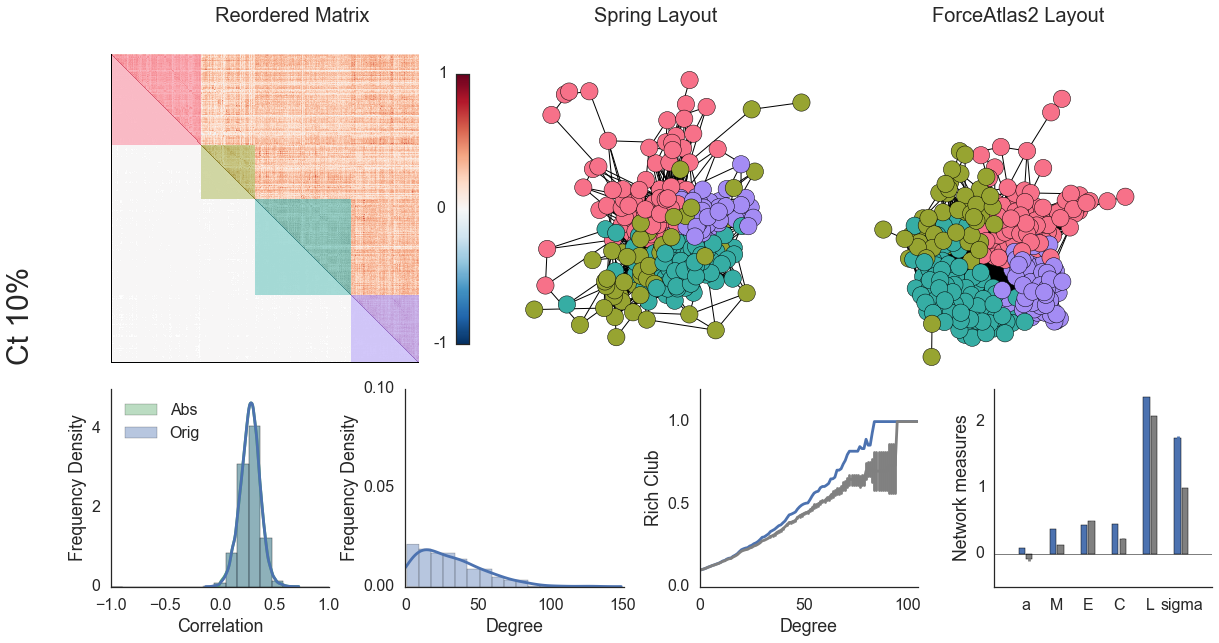

In [16]:
CT_mat_file = ('../../../../GitHub/NSPN_WhitakerVertes_PNAS2016/CT_MT_ANALYSES/COMPLETE/CORR_MATS/COVARS_ONES/Mat_CT_Corr_ALL.txt')

for cost in [ 10 ]:    
    # CT network
    plotting_dict = None
    plotting_dict = show_network(CT_mat_file,
                                     n_rand=2,
                                     cost=cost,
                                     plotting_dict = plotting_dict,
                                     sep='\t',
                                    header=None)

In [ ]:
plotting_dict = results_dict['pathology_cost_10']

print np.min(np.where(plotting_dict['rc']>0.8))

plotting_dict.keys()

In [ ]:
df = pd.read_csv('Corr_all_ModuleItems_Cost_10.csv', header=None)
df.T.to_csv('testing.csv', index=None, header=None)

In [ ]:
corr_mat_df = pd.read_csv('Corr_all.csv')
M = corr_mat_df.values
M_abs = np.abs(M)
G = graph_at_cost(M_abs, 10)
M_cost = nx.to_numpy_matrix(G)
for u,v,d in G.edges(data=True):
    d['weight'] = 1

In [ ]:
pos = nx.spring_layout(G)
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 pos=pos, 
                 node_color=plotting_dict['nodal_colors'],
                 with_labels=False,
                 ax=ax)

In [ ]:
print results_dict['all_cost_10']['pos_spring'][1]
print pos[1]

In [ ]:
thr_M = np.copy(M_abs)
thr_M[np.diag_indices_from(thr_M)] = 0
thr_M = thr_M*-1

G = nx.from_numpy_matrix(thr_M)

mst = nx.minimum_spanning_tree(G)
mst_edges = mst.edges(data=True)
G_edges_sorted = [ edge for edge in sorted(G.edges(data=True), key = lambda (a, b, dct) : dct['weight']) ]


In [ ]:
mst

In [ ]:
mst = G.remove_edge

In [ ]:
cost = 10

for cost in [ 5, 10, 15]:
    for measure in [ 'a', 'M', 'E', 'C', 'L', 'sigma']:
        row = []
        for group in [ 'pathology', 'personality', 'all']:
            real_mean = np.mean(results_dict['{}_cost_{}'.format(group, cost)]['global_measures'][measure])
            real_l = np.percentile(results_dict['{}_cost_{}'.format(group, cost)]['global_measures'][measure], 5)
            real_u = np.percentile(results_dict['{}_cost_{}'.format(group, cost)]['global_measures'][measure], 95)
            rand_mean = np.mean(results_dict['{}_cost_{}'.format(group, cost)]['global_measures']['{}_rand'.format(measure)])
            rand_l = np.percentile(results_dict['{}_cost_{}'.format(group, cost)]['global_measures']['{}_rand'.format(measure)], 5)
            rand_u = np.percentile(results_dict['{}_cost_{}'.format(group, cost)]['global_measures']['{}_rand'.format(measure)], 95)
            if not measure == 'sigma':
                row += [ '{:2.2f} ({:2.2f} [{:2.2f},{:2.2f}])'.format(real_mean, rand_mean, rand_l, rand_u) ]
            else:
                row += [ '{:2.2f} [{:2.2f},{:2.2f}] ({:2.2f})'.format(real_mean, real_l, real_u, rand_mean) ]
        print '|'.join(row)
    print '------'

In [ ]:
for corr_mat_file in [ 'Corr_pathology.csv', 'Corr_personality.csv', 'Corr_all.csv']:
    corr_mat_df = pd.read_csv(corr_mat_file)
    M = corr_mat_df.values
    print os.path.basename(corr_mat_file).split('_')[1].replace('.csv', '').capitalize(), M.shape
    M = corr_mat_df.values
    M_abs = np.abs(M)
    print M.shape[0]/30.0
    
    print np.mean(M_abs[np.triu_indices_from(M_abs, 1)])

In [ ]:
plot_corr_dist(M)
M[np.triu_indices_from(M, 1)].shape

In [ ]:

nodal_partition = calc_nodal_partition(G)
module_partition, module_order, module_colors, nodal_colors = color_by_module(nodal_partition)

n_modules = len(module_partition.keys())
print n_modules
print len(nodal_partition)

fig, ax_list = plt.subplots(3, 6, figsize=(18,18))

plt.subplots_adjust(hspace=0, wspace=0, left=0.1, right=0.98, top=0.98, bottom=0.02)

ax_list = ax_list.reshape(-1)
ax_id = 0

for i, module in enumerate(module_partition.keys()):
    item_list = ['{}'.format(module)]
    for item in module_partition[module]:
        item_list += [corr_mat_df.columns[item]]
    
    n_cols = len(item_list)/30 + 1
    
    for col in range(n_cols):
        ax = ax_list[ax_id]
        ax.text(0.1, 0.95, 
                    '\n'.join(item_list[30*col:30*(col+1)]), 
                    horizontalalignment='left',
                    verticalalignment='top',
                    fontsize=10)
        ax_id += 1
    
        ax.add_patch(patches.Rectangle((0, 0), 1, 1, facecolor=module_colors[i], edgecolor='none', alpha=0.7))

for ax in ax_list:
    ax.axis('off')

fig.savefig('testing.png', bbox_inches=0, dpi=50)

In [ ]:
corr_mat_reorder_df = corr_mat_df.iloc[module_order, module_order]
M_reorder = corr_mat_reorder_df.values
M_mask=np.ma.array(M_reorder,mask=np.triu(M_reorder))

M_cost = nx.to_numpy_matrix(G)
M_cost = M_cost[module_order, :]
M_cost = M_cost[:, module_order]
M_cost = np.tril(M_cost)
M_mask=np.ma.masked_where(M_cost==0, M_cost)



In [ ]:
1/8

In [ ]:
plt.imshow(M_reorder, cmap='RdBu_r', interpolation='none')
plt.imshow(M_mask, cmap='Greys_r', interpolation='none')

In [ ]:
global_measures_dict = calculate_global_measures(G, n_rand=10)

In [ ]:
sns.distplot(M.reshape(-1), bins=np.arange(-1, 1, .1), label='raw')
sns.distplot(np.abs(M.reshape(-1)), bins=np.arange(-1, 1, .1), label='abs')
plt.legend()
plt.title('Correlations')
plt.gca().set_xlim([-1, 1])

In [ ]:
thr_M = np.copy(M)
thr_M[np.diag_indices_from(thr_M)] = 0


In [ ]:
np.arange(-1, 1, .1)
np.linspace(-1, 1, 20).shape

In [ ]:
plot_corr_dist(M)